<a href="https://colab.research.google.com/github/laura314159265/poly/blob/main/SIMULACI%C3%93_A/Optimitzaci%C3%B3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

L'angle d'inclinació òptim del panell respecte al terra és: 40.41404140414041


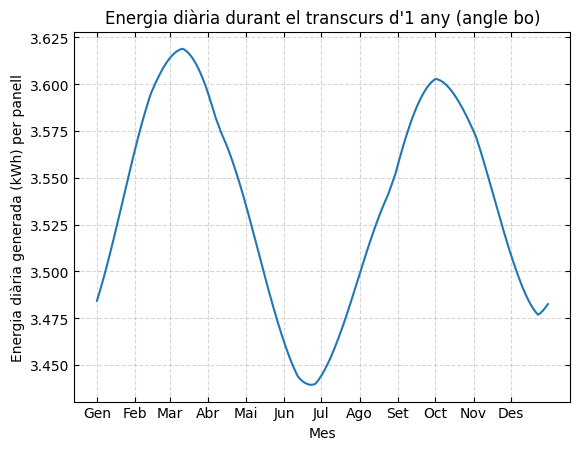

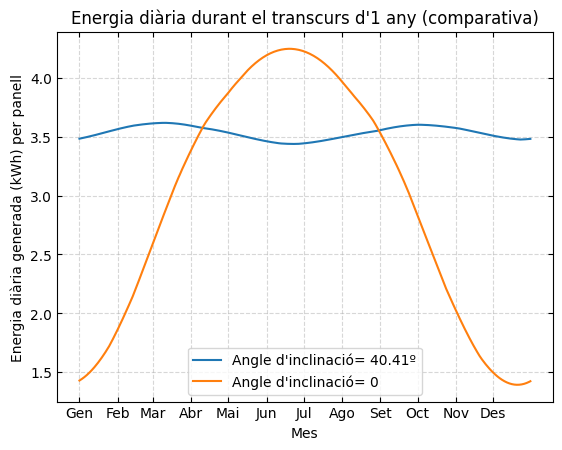

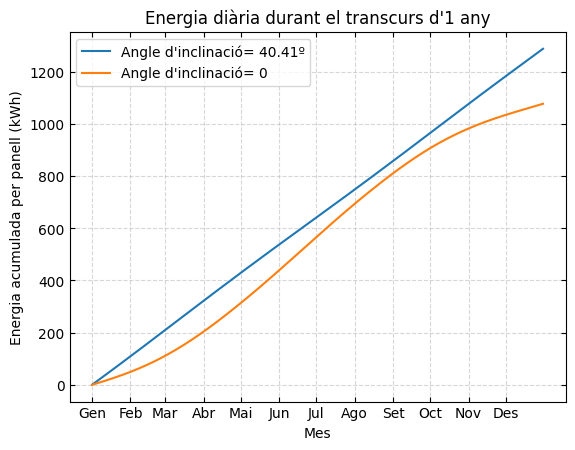

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import copy
from datetime import date, timedelta

# Dades en unitats del SI
G= 6.67430e-11
m_sol= 1.98847e30
m_terra= 5.97219e24
m_lluna= 7.349e22
m_mart= 6.4171e23

# Condicions inicials (en cartesianes)
# L'origen és el baricentre del sistema solar
# Format: [x,y,z,vx,vy,vz]
# Inici a les 13:59 del 21 de Juny del 2025 (solstici d'estiu)
# Això és per el temps central Europeu, per tant hi ha un lleuger error
# Ja que no està a Bellaterra/Barcelona exactament
# Posicions en kilometres i velocitats en km/s

lluna= np.array([-1.223926839954494E+05, -1.526112945830738E+08, 5.512426765490323E+04, 2.865929048320844E+01, 7.673984990113614E-01, 6.367954754048094E-02])
terra= np.array([-4.133776082794621E+05, -1.528302631740358E+08, 3.242787546376139E+04, 2.932642969193051E+01, -7.378251008835289E-02, -1.172300942425906E-03])
sol= np.array([-6.709778526787314E+05, -8.035450223548296E+05, 2.366174814126350E+04, 1.263745636318025E-02, -3.212119035252178E-03, -2.265926685896345E-04])

# Normalització
t0= 86400.0            # Temps característic= 1 dia
m0= m_sol              # Massa característica= massa del sol
r0= (G * t0**2 * m0)**(1/3)  # Radi característic

def normalitza(cos):
  pos = cos[:3]*(1/r0)*10**3
  vel = cos[3:]*(t0/r0)*10**3
  return pos, vel

masses= np.array([m_sol/m0, m_terra/m0, m_lluna/m0])
pos_sol, vel_sol= normalitza(sol)
pos_terra, vel_terra= normalitza(terra)
pos_lluna, vel_lluna= normalitza(lluna)
posicions= np.array([pos_sol, pos_terra, pos_lluna])
velocitats= np.array([vel_sol, vel_terra, vel_lluna])

def acceleracions(pos, masses): # pos és una matriu de N files i 3 columnes
    N= len(masses) # Nombre de cossos: planetes, el Sol i la Lluna
    acc= np.zeros_like(pos) # Crea un array amb la mateixa forma que pos però ple de zeros
    for i in range(N):
        for j in range(N):
            if i != j:  # Si i ≠ j, perquè un cos no s'atrau a ell mateix
                diff= pos[j] - pos[i]
                d= np.linalg.norm(diff) # Calcula la norma del vector diferència de posicions
                acc[i]= acc[i] + masses[j] * diff / d**3
    return acc

def rk4(pos, vel, masses, h):
    K1= vel
    L1= acceleracions(pos, masses)
    K2= vel + 0.5*h*L1
    L2= acceleracions(pos + 0.5*h*K1, masses)
    K3= vel + 0.5*h*L2
    L3= acceleracions(pos + 0.5*h*K2, masses)
    K4= vel + h*L3
    L4= acceleracions(pos + h*K3, masses)
    pos_nou= pos + (h/6)*(K1 + 2*K2 + 2*K3 + K4)
    vel_nou= vel + (h/6)*(L1 + 2*L2 + 2*L3 + L4)
    return pos_nou, vel_nou


def acumular(llista): #Funció acumulat d'un array (el numpy probablement tingui una millor)
  acum_array=[]
  for i in range(len(llista)):
    acum_array.append(np.sum(llista[:i]))
  return np.array(acum_array)

t_f = 365
dt = 1/24
hores= int(t_f/dt)
passos = hores +6  #per tenir en compte que un any dura 365 dies i 6 hores afegim 5 + CI = 6 hores "extres" als 365 dies calculats
#AIXÒ ENS DONA L'HORA JUST ABANS DE RETORNAR A LES CONDICIONS INICIALS. SI VOLEM TROBAR EL MOMENT DEL QUE HEM PARTIT PERO UN ANY DESPRÉS HEM DE POSAR EL TEMPS SEGÜENT ÉS A DIR UN + 6

pos_hist = np.zeros((passos+2, len(masses), 3), dtype=float)
vel_hist = np.zeros((passos+2, len(masses), 3), dtype=float)
pos_hist[0] = posicions
vel_hist[0] = velocitats

for i in range(passos+1):
  pos_nou, vel_nou = rk4(pos_hist[i], vel_hist[i], masses, dt)
  pos_hist[i+1] = pos_nou
  vel_hist[i+1] = vel_nou

# Extreure trajectòries
idx_sol = 0
idx_terra = 1

x_t = pos_hist[:, idx_terra, 0]
y_t = pos_hist[:, idx_terra, 1]
z_t = pos_hist[:, idx_terra, 2]

x_s = pos_hist[:, idx_sol, 0]
y_s = pos_hist[:, idx_sol, 1]
z_s = pos_hist[:, idx_sol, 2]

# Volem el vector que uneix sol i terra llavors farem el vector baricentre-Terra menys el vector baricentre-Sol

R_t = 6371000 #metres
vel_ang = 2*np.pi/23.9344444 # en rad/h
theta = (23.43333333333333*2*np.pi)/360
phi= (41.505833333*2*np.pi)/360

# Per, a continuació, rotar respecte l'eix x aquest vector un angle alpha (la inclinació dels panells respecte la horitzontal) %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# I trobar angle d'inclinació que maximitza la suma dels cosinus de l'angle entre la normal al panell i els rajos de sol.

t = np.linspace(0, passos, passos+1)

k = np.array([0, np.sin(theta), np.cos(theta)])

def rodrigues (alpha): #Formula de rodrigues per un panel inclinat un angle alpha al sud al voltant del eix de rotació de la Terra
  x = np.array([0])
  y = np.array([R_t*np.sin(alpha + np.pi/2 - (phi-theta))])
  z = np.array([R_t*np.cos(alpha + np.pi/2 - (phi-theta))])
  X = np.concatenate((x,(R_t * np.sin(vel_ang * t))*(-np.cos(theta)*np.sin(alpha + np.pi/2 - (phi-theta)) + np.sin(theta)*np.cos(alpha + np.pi/2 - (phi-theta)))))
  Y = np.concatenate((y,(np.sin(alpha + np.pi/2 - (phi-theta))*np.cos(vel_ang*t) + np.sin(theta)*(np.sin(theta)*np.sin(alpha + np.pi/2 - (phi-theta)) + np.cos(theta)*np.cos(alpha + np.pi/2 - (phi-theta)))*(1 - np.cos(vel_ang*t))) * R_t))
  Z = np.concatenate((z,(np.cos(alpha + np.pi/2 - (phi-theta))*np.cos(vel_ang*t) + np.cos(theta)*(np.sin(theta)*np.sin(alpha + np.pi/2 - (phi-theta)) + np.cos(theta)*np.cos(alpha + np.pi/2 - (phi-theta)))*(1 - np.cos(vel_ang*t))) * R_t))
  return X, Y, Z

x_st = r0 * (x_t - x_s)
y_st = r0 * (y_t - y_s)
z_st = r0 * (z_t - z_s)


#angle entre la normal al panell i un raig de Sol

latitud = 41.50320 * np.pi / 180   # Latitud Bellaterra en radians

def unit(v):
    n = np.linalg.norm(v)
    return v / n


def emergy(alpha):

  res= rodrigues(alpha)
  X_b = res[0]
  Y_b = res[1]
  Z_b = res[2]
  mod_t = np.sqrt(x_st**2 + y_st**2 + z_st**2)
  Mod_b = np.sqrt(X_b**2 + Y_b**2 + Z_b**2)
  cos_llista = (X_b * x_st + Y_b * y_st + Z_b * z_st)/(Mod_b * mod_t)
  theta_llista = np.pi - np.arccos(cos_llista) #Angle entre la normal del panell i el sol

  h= 1/24
  periode_dia = 24 * 3600

  I_rebuda = (695508000**2 / mod_t**2) * 0.99 * 5.670374419 * 10**(-8) * 5778**4 * np.maximum(0, np.cos(theta_llista))

  area_panell = 2
  pot_max = 400
  I_saturacio = 1000

  dt_energia = h * periode_dia

  pot = pot_max * (I_rebuda / I_saturacio)
  pot = np.minimum(pot, pot_max)

  hores_dia = int(1/h)
  hores_simulacio = len(pot)
  dies_simulacio = hores_simulacio // hores_dia
  pot_reshaped = pot[:dies_simulacio * hores_dia].reshape(dies_simulacio, hores_dia)

  energia_diaria_kWh = np.sum(pot_reshaped, axis=1) * dt_energia / 3.6e6
  energia_panell_any_kWh = np.sum(energia_diaria_kWh)

  data_inici_simulacio= date(2025, 6, 21)
  dates= [data_inici_simulacio + timedelta(days=i) for i in range(365)]
  idx_jan1= None
  for i, d_date in enumerate(dates):
      if d_date.month == 1 and d_date.day == 1:
          idx_jan1= i
          break
  if idx_jan1 is not None:
      energia_diaria_kWh_plot= np.roll(energia_diaria_kWh, -idx_jan1)
  else:
      energia_diaria_kWh_plot= energia_diaria_kWh

  return energia_diaria_kWh, energia_diaria_kWh_plot

#LINSPACE D'ANGLES D'INCLINACIÓ DEL PANELL CANDIDATS A SER the G.O.A.T.
alphes =np.linspace(0, 90*2*np.pi/360, 10000)
energia_total= []

for alpha in alphes:
  energia_total.append(np.sum(emergy(alpha)[0]))

optim_angle= alphes[energia_total.index(max(energia_total))]  #Trobem l'angle òptim en radians

print("L'angle d'inclinació òptim del panell respecte al terra és:", optim_angle*180/np.pi) #Això ens dona l'índex en el linspace d'alphes de l'inclinació del panell òptima

energia_optima= emergy(optim_angle)[1]
energia_0= emergy(0)[1]


# Gràfic energia diària al llarg de l'any per l'àngle "òptim"
plt.figure()
dies_any= np.arange(1, 366)
plt.plot(dies_any, energia_optima)

inicis_mes= np.array([1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335])
noms_mes= ["Gen", "Feb", "Mar", "Abr", "Mai", "Jun", "Jul", "Ago", "Set", "Oct", "Nov", "Des"]
plt.xticks(inicis_mes, noms_mes)

plt.xlabel("Mes")
plt.ylabel("Energia diària generada (kWh) per panell")
plt.title("Energia diària durant el transcurs d'1 any (angle bo)")
plt.tick_params(axis='both', direction='in', top=True, right=True)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Gràfic energia diària al llarg de l'any per angle 0
plt.figure()
dies_any= np.arange(1, 366)
plt.plot(dies_any, energia_optima, label=f"Angle d'inclinació= {optim_angle*180/np.pi:.2f}º")
plt.plot(dies_any, energia_0, label="Angle d'inclinació= 0")

inicis_mes= np.array([1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335])
noms_mes= ["Gen", "Feb", "Mar", "Abr", "Mai", "Jun", "Jul", "Ago", "Set", "Oct", "Nov", "Des"]
plt.xticks(inicis_mes, noms_mes)

plt.xlabel("Mes")
plt.ylabel("Energia diària generada (kWh) per panell")
plt.title("Energia diària durant el transcurs d'1 any (comparativa)")
plt.tick_params(axis='both', direction='in', top=True, right=True)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

# Plot de tenir l'angle bo o plantar el panell pla al terra xd

plt.figure()
dies_any= np.arange(1, 366)

plt.plot(dies_any, acumular(energia_optima), label=f"Angle d'inclinació= {optim_angle*180/np.pi:.2f}º")
plt.plot(dies_any, acumular(energia_0), label="Angle d'inclinació= 0")
#plt.plot(dies_any, np.abs(emergy(optim_angle)[1]-emergy(0)[1]), label="diferència dels 2 lol")

inicis_mes= np.array([1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335])
noms_mes= ["Gen", "Feb", "Mar", "Abr", "Mai", "Jun", "Jul", "Ago", "Set", "Oct", "Nov", "Des"]
plt.xticks(inicis_mes, noms_mes)

plt.xlabel("Mes")
plt.ylabel("Energia acumulada per panell (kWh)")
plt.title("Energia diària durant el transcurs d'1 any")
plt.tick_params(axis='both', direction='in', top=True, right=True)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

#AQUESTA MERDA TRIGA COM 23s A PLOTAR, SIGUIN PACIENTS


Energia anual per panell (kWh/any): 1290.8459819552077
Panells òptims per cobrir l'objectiu: 1.726774558048976


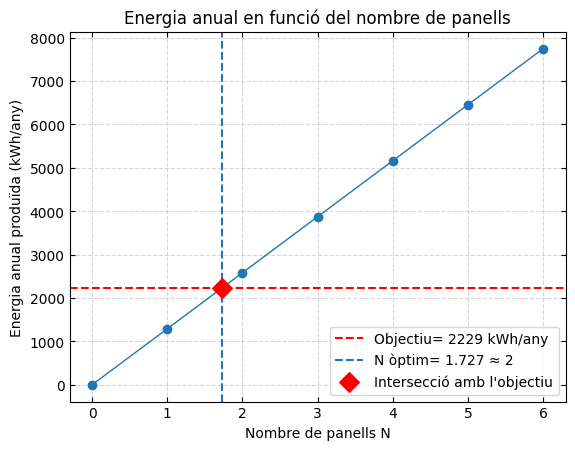

NameError: name 'eix_rotacio' is not defined

In [13]:
# Nombre òptim de panells

objectiu_kWh_any= 2229 # Consum anual mitjà a Barcelona (kWh/any), el farem servir com a objectiu
energia_panell_any_kWh= np.sum(emergy(optim_angle)[0])
N_optim= objectiu_kWh_any / energia_panell_any_kWh
N_optim_enter= int(np.ceil(N_optim))

print("Energia anual per panell (kWh/any):", energia_panell_any_kWh)
print("Panells òptims per cobrir l'objectiu:", N_optim)

# Energia anual en funció del nombre de panells
max_panells_plot= int(max(6, 2 * N_optim))
n_panells= np.arange(0, max_panells_plot + 1)

energia_total_kWh= n_panells * energia_panell_any_kWh

plt.figure()
plt.plot(n_panells, energia_total_kWh, marker='o', linewidth=1)
plt.axhline(objectiu_kWh_any, linestyle='--', color="red", label=f"Objectiu= {objectiu_kWh_any:.0f} kWh/any")
plt.axvline(N_optim, linestyle='--', label=f"N òptim= {N_optim:.3f} \u2248 {N_optim_enter}")
plt.scatter([N_optim], [N_optim * energia_panell_any_kWh], marker='D', color='red', s=100, label="Intersecció amb l'objectiu", zorder=5)
plt.xlabel("Nombre de panells N")
plt.ylabel("Energia anual produïda (kWh/any)")
plt.title("Energia anual en funció del nombre de panells")
plt.tick_params(axis='both', direction='in', top=True, right=True)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

energia_total_kWh= n_panells * energia_panell_any_kWh

# Energia ANUAL EN FUNCIÓ DE LA INCLINACIÓ DEL PANELL (alpha)
# alpha= 0° horitzontal, alpha= 90° vertical
# Triem panell orientat cap al SUD (azimut sud) per maximitzar

# Gràfica
plt.figure()
plt.plot(alphas_graus, energia_any_alpha, marker='o', linewidth=1)
plt.scatter([alpha_optim_graus], [energia_max_kWh_any], marker='*', color='red', s=220, label=fr"$\alpha_{{opt}}$= {alpha_optim_graus:.1f}°", zorder=5)
plt.xlabel("Angle d'inclinació del panell respecte al terra, \u03B1 (graus)")
plt.ylabel("Energia anual per panell (kWh/any)")
plt.title("Energia anual en funció de la inclinació (orientació sud)")
plt.tick_params(axis='both', direction='in', top=True, right=True)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

